In [40]:
import sys
sys.version_info

sys.version_info(major=3, minor=11, micro=4, releaselevel='final', serial=0)

In [1]:
import requests
import pandas as pd
import numpy as np
import json
from urllib.parse import urlparse, parse_qs, urlencode, urlunparse
from matplotlib import pyplot as plt
import seaborn as sns
import time
import glob
import re

# Data Science Marathon

## Getting Data

Instead of running a lot of marathons and timing we just access the widely availavle results data. In Berlin this is especially convenient as the site supports an API returning a JSON for the older marathon results. Not that are slight differences both in the exact syntax of the call and im the structure of the result over the years. If you interactively use the site und track the traffic with eg Chrome developer tools it is quite easy to sse get examples.

We adapt some parameters as the website is geared towards displaying a small number of filtered results whereas we want simply everything. In the concrete example for 2008 it is as follows:
- `start`: At which record to start, 0 based.
- `ci`: The compettion, `MAL`for the marathon.
- `y`: The year the competition took pöace.
- `lenght`: The number of records to fetch with one call.

The actual data is in the data tag of the JSON. We simply use Pandas to create a data frame out of the JSON and join the data frames in a loop to get all the results. Finally we store it as a CSV for reuse.

In [86]:
my_url = "https://api.results.scc-events.com/result?ek=BM&ci=BML&y=2022&draw=2&columns%5B0%5D%5Bdata%5D=platz&columns%5B0%5D%5Bname%5D=&columns%5B0%5D%5Bsearchable%5D=true&columns%5B0%5D%5Borderable%5D=true&columns%5B0%5D%5Bsearch%5D%5Bvalue%5D=&columns%5B0%5D%5Bsearch%5D%5Bregex%5D=false&columns%5B1%5D%5Bdata%5D=startnummer&columns%5B1%5D%5Bname%5D=&columns%5B1%5D%5Bsearchable%5D=true&columns%5B1%5D%5Borderable%5D=false&columns%5B1%5D%5Bsearch%5D%5Bvalue%5D=&columns%5B1%5D%5Bsearch%5D%5Bregex%5D=false&columns%5B2%5D%5Bdata%5D=nachname&columns%5B2%5D%5Bname%5D=&columns%5B2%5D%5Bsearchable%5D=true&columns%5B2%5D%5Borderable%5D=false&columns%5B2%5D%5Bsearch%5D%5Bvalue%5D=&columns%5B2%5D%5Bsearch%5D%5Bregex%5D=false&columns%5B3%5D%5Bdata%5D=vorname&columns%5B3%5D%5Bname%5D=&columns%5B3%5D%5Bsearchable%5D=true&columns%5B3%5D%5Borderable%5D=false&columns%5B3%5D%5Bsearch%5D%5Bvalue%5D=&columns%5B3%5D%5Bsearch%5D%5Bregex%5D=false&columns%5B4%5D%5Bdata%5D=verein&columns%5B4%5D%5Bname%5D=&columns%5B4%5D%5Bsearchable%5D=true&columns%5B4%5D%5Borderable%5D=true&columns%5B4%5D%5Bsearch%5D%5Bvalue%5D=&columns%5B4%5D%5Bsearch%5D%5Bregex%5D=false&columns%5B5%5D%5Bdata%5D=nation&columns%5B5%5D%5Bname%5D=&columns%5B5%5D%5Bsearchable%5D=true&columns%5B5%5D%5Borderable%5D=false&columns%5B5%5D%5Bsearch%5D%5Bvalue%5D=&columns%5B5%5D%5Bsearch%5D%5Bregex%5D=false&columns%5B6%5D%5Bdata%5D=sex&columns%5B6%5D%5Bname%5D=&columns%5B6%5D%5Bsearchable%5D=true&columns%5B6%5D%5Borderable%5D=true&columns%5B6%5D%5Bsearch%5D%5Bvalue%5D=&columns%5B6%5D%5Bsearch%5D%5Bregex%5D=false&columns%5B7%5D%5Bdata%5D=ak&columns%5B7%5D%5Bname%5D=&columns%5B7%5D%5Bsearchable%5D=true&columns%5B7%5D%5Borderable%5D=true&columns%5B7%5D%5Bsearch%5D%5Bvalue%5D=&columns%5B7%5D%5Bsearch%5D%5Bregex%5D=false&columns%5B8%5D%5Bdata%5D=ak_plazierung&columns%5B8%5D%5Bname%5D=&columns%5B8%5D%5Bsearchable%5D=true&columns%5B8%5D%5Borderable%5D=true&columns%5B8%5D%5Bsearch%5D%5Bvalue%5D=&columns%5B8%5D%5Bsearch%5D%5Bregex%5D=false&columns%5B9%5D%5Bdata%5D=netto&columns%5B9%5D%5Bname%5D=&columns%5B9%5D%5Bsearchable%5D=true&columns%5B9%5D%5Borderable%5D=true&columns%5B9%5D%5Bsearch%5D%5Bvalue%5D=&columns%5B9%5D%5Bsearch%5D%5Bregex%5D=false&columns%5B10%5D%5Bdata%5D=brutto&columns%5B10%5D%5Bname%5D=&columns%5B10%5D%5Bsearchable%5D=true&columns%5B10%5D%5Borderable%5D=true&columns%5B10%5D%5Bsearch%5D%5Bvalue%5D=&columns%5B10%5D%5Bsearch%5D%5Bregex%5D=false&columns%5B11%5D%5Bdata%5D=&columns%5B11%5D%5Bname%5D=&columns%5B11%5D%5Bsearchable%5D=true&columns%5B11%5D%5Borderable%5D=false&columns%5B11%5D%5Bsearch%5D%5Bvalue%5D=&columns%5B11%5D%5Bsearch%5D%5Bregex%5D=false&columns%5B12%5D%5Bdata%5D=&columns%5B12%5D%5Bname%5D=&columns%5B12%5D%5Bsearchable%5D=true&columns%5B12%5D%5Borderable%5D=false&columns%5B12%5D%5Bsearch%5D%5Bvalue%5D=&columns%5B12%5D%5Bsearch%5D%5Bregex%5D=false&columns%5B13%5D%5Bdata%5D=&columns%5B13%5D%5Bname%5D=&columns%5B13%5D%5Bsearchable%5D=true&columns%5B13%5D%5Borderable%5D=false&columns%5B13%5D%5Bsearch%5D%5Bvalue%5D=&columns%5B13%5D%5Bsearch%5D%5Bregex%5D=false&order%5B0%5D%5Bcolumn%5D=0&order%5B0%5D%5Bdir%5D=asc&start=0&length=100&search%5Bvalue%5D=&search%5Bregex%5D=false"

# Parse the URL
parsed_url = urlparse(my_url)
# Get the query parameters as a dictionary
query_params = parse_qs(parsed_url.query)
# Update the value of the 'start' parameter
query_params['start'] = ['0']
# Update the value of the year parameter
query_params['ci'] = ['MAL']
query_params['y'] = ['2008']
# Update the value of the 'length' parameter
query_params['length'] = ['1000']
# Encode the updated query parameters
encoded_params = urlencode(query_params, doseq=True)
# Create the updated URL by replacing the query parameters
my_url = urlunparse(parsed_url._replace(query=encoded_params))

my_response = requests.get(my_url)
my_json = my_response.json()

# we just need the total records
my_records = int(my_json['recordsTotal'])

start = 0
results_df = pd.DataFrame()

while start <= my_records:
    my_response = requests.get(my_url)
    my_json = my_response.json()
    df = pd.DataFrame(my_json['data'])
    results_df = pd.concat((results_df, df), ignore_index=True)
    start = start + 1000
    parsed_url = urlparse(my_url)
    query_params = parse_qs(parsed_url.query)
    query_params['start'] = [str(start)]
    encoded_params = urlencode(query_params, doseq=True)
    my_url = urlunparse(parsed_url._replace(query=encoded_params))
    time.sleep(1)

results_df.to_csv("berlin2008.csv")

results_df

,id,platz,startnummer,name,nachname,vorname,verein,nation,jahrgang,ak,...,z15,z20,z25,z30,z35,z40,halbmarathon,netto,brutto,ident
0,38823,1,1,"Gebrselassie, Haile",Gebrselassie,Haile,,ETH,1973,M35,...,00:44:03,00:58:50,01:13:41,01:28:27,01:43:05,01:57:34,01:02:05,02:03:59,02:03:59,MAL
1,38831,2,10,"Kwambai, James",Kwambai,James,,KEN,1983,MH,...,00:44:03,00:58:51,01:13:41,01:28:27,01:43:05,01:58:27,01:02:05,02:05:36,02:05:36,MAL
2,38824,3,2,"Kamathi, Charles",Kamathi,Charles,,KEN,1978,M30,...,00:44:03,00:58:51,01:13:41,01:28:27,01:43:50,02:00:31,01:02:05,02:07:48,02:07:48,MAL
3,52684,4,97,"Kipchumba, Mariko",Kipchumba,Mariko,,KEN,1976,M30,...,00:45:44,01:01:29,01:17:09,01:32:18,01:47:16,02:02:24,01:04:54,02:09:03,02:09:03,MAL
4,38830,5,9,"Ademasu, Mesfin",Ademasu,Mesfin,,ETH,1985,MH,...,00:46:20,01:02:36,01:18:23,01:34:31,01:50:32,02:05:37,01:06:04,02:12:02,02:12:02,MAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35727,26749,35742,F4628,"Klee, Susi",Klee,Susi,,CHE,1950,W55,...,02:04:13,02:47:31,03:35:18,00:00:00,05:31:05,06:29:59,02:57:21,06:53:46,07:00:01,MAL
35728,6626,35743,24907,"Rudy, John L.",Rudy,John L.,,USA,1978,M30,...,01:58:24,02:40:25,03:36:02,04:33:23,05:29:44,06:30:49,02:52:17,06:54:22,06:59:09,MAL
35729,6623,35744,F5608,"Marino, Genevieve",Marino,Genevieve,,USA,1982,WH,...,01:58:24,02:40:25,03:36:03,04:33:24,05:29:45,06:30:49,02:52:18,06:54:23,06:59:09,MAL
35730,29881,35745,F5666,"Mason, Tonya",Mason,Tonya,,USA,1971,W35,...,02:12:13,03:00:25,03:52:46,00:00:00,00:00:00,06:33:48,03:12:42,06:56:36,06:59:20,MAL


## Reading Data

Assuming we stored a number of Marathons in CSV we files we read them and store them in a dcitionary for now. While at it we also create a dictionary with the column names of the CSV files. These would have been determined by the exact structure of the JSON respnonse when using an API or how the web scraper was configured when scraping the data from an interactive web site.

In [54]:
# Glob pattern to match CSV files
csv_files = glob.glob("*.csv")

df_dict = {}
col_dict = {}

# Read the CSV files as data drames in a dictionary and store the columns
for file in csv_files:
    df_dict[file] = pd.read_csv(file)
    col_dict[file] = df_dict[file].columns

This gives us an overview over all the files we read. In addition we get the unique variants of column names. Not that besiders varying columns names sometimes also the formatting of the content changes. 

In [3]:
cols_set = set()

for key in col_dict.keys():
    print(key)
    cols_set.add(str(col_dict[key].values))

cols_set

berlin2023.csv
Muenchen2013.csv
Muenchen2008 Maenner.csv
Muenchen2012.csv
berlin2022.csv
berlin2008.csv
Muenchen2010.csv
Muenchen2011.csv
berlin2009.csv
berlin2021.csv
berlin2019.csv
Muenchen2015.csv
Muenchen2014.csv
berlin2018.csv
Muenchen2008 Frauen.csv
Muenchen2016.csv
Muenchen2017.csv
berlin2016.csv
berlin2017.csv
berlin2015.csv
Muenchen2019.csv
Muenchen2018.csv
berlin2014.csv
berlin2010.csv
Muenchen2021.csv
berlin2011.csv
berlin2013.csv
Muenchen2023.csv
berlin2012.csv
Muenchen2009 Frauen.csv
Muenchen2009 Maenner.csv


{"['Unnamed: 0' 'id' 'event' 'ident' 'description' 'startnummer' 'name'\n 'vorname' 'nachname' 'sex' 'jahrgang' 'ak' 'nation' 'verein'\n 'sex_plazierung' 'platz' 'ak_plazierung' 'netto' 'brutto' 'z5' 'z10'\n 'z15' 'z20' 'halbmarathon' 'z25' 'z30' 'z35' 'z38' 'z40' 'personen_id'\n 'participant_id']",
 "['Unnamed: 0' 'id' 'platz' 'startnummer' 'name' 'nachname' 'vorname'\n 'verein' 'nation' 'jahrgang' 'ak' 'ak_plazierung' 'sex' 'sex_plazierung'\n 'z5' 'z10' 'z15' 'z20' 'z25' 'z30' 'z35' 'z40' 'halbmarathon' 'netto'\n 'brutto' 'ident' 'starttime' 'pid']",
 "['Unnamed: 0' 'id' 'platz' 'startnummer' 'name' 'nachname' 'vorname'\n 'verein' 'nation' 'jahrgang' 'ak' 'ak_plazierung' 'sex' 'sex_plazierung'\n 'z5' 'z10' 'z15' 'z20' 'z25' 'z30' 'z35' 'z40' 'halbmarathon' 'netto'\n 'brutto' 'ident' 'starttime']",
 "['Unnamed: 0' 'id' 'platz' 'startnummer' 'name' 'nachname' 'vorname'\n 'verein' 'nation' 'jahrgang' 'ak' 'ak_plazierung' 'sex' 'sex_plazierung'\n 'z5' 'z10' 'z15' 'z20' 'z25' 'z30' 'z35' 

## Standardizing Berlin Marathon Data

Now the unpleasant part of standardizing the data and checking for datas quality starts. We first look at the Berlin marathon data we got over the API. This data is relatively easy to handle as it is quite standardized across the years. There are some slight differencese however where we need to standardize the data. Forgetting about these standardizations will invariably lead to problems when working with the data analytically. On the other hand typically these issues are detected when doing some exploratory data analysis.

Some examples here are:
- Germany was abrreviated as DEU which is the ISO country code for Germany. Later GER is used which is more common in sports.
- The age grouo (Altersklasse in German) in later years did not contain the sex anymore. We put it in for all years as it is easier to group like that.
- The younger age groups are not standardised over the years. We use MJ and WJ as catch-alls where the J stands for adolescent. The ansolute numbers of participants are small.

There are also some quality issues with times, Every participant should have a gross (brutto) and a net (netto) time. The gross time should always be greater or equal than the net time. For very few participants one or both of these times are 0. We  drop all runners where one of the times is lower than an hour to be on the safer side.

### Scraped Data

The data we retrieved throught web scraping is more heterogeneous than data retrieved over an API. We must do some preprocessing on the data to adapt the structure to what we retrieved over the API. The 2023 Berlin marathon was only available on the website and not yet over the API.

In [55]:
def split_name(name):
    pattern = re.compile(r"(\w*),\s(\w*) \((\w*)\)")
    if pattern.search(name) != None:
        return(pattern.search(name).groups())
    else:
        return ("", "", "")

df = df_dict["berlin2023.csv"].copy()

# Rename the columns as retrieved over the API
df.rename(columns={"Platz" : "platz", "PlatzAK" : "ak_plazierung", "StartNr" : "startnummer", "Altersklasse" : "ak", 
                   "BruttoZeit" : "brutto", "NettoZeit" : "netto", "Verein" : "verein"}, inplace=True)

# Split the scraped name into separate fields
df["nachname"] = df["Name"].apply(lambda x : split_name(x)[0])
df["vorname"] = df["Name"].apply(lambda x : split_name(x)[1])
df["nation"] = df["Name"].apply(lambda x : split_name(x)[2])
# Correct some further formatting issues
df["ak"] = df["ak"].apply(lambda x : x[2:])
df["startnummer"] = df["startnummer"].apply(lambda x : x[8:])
df["startnummer"] = df["startnummer"].str.replace('F', '')
df["sex"] = df["ak"].apply(lambda x : x[0])
df["brutto"] = df["brutto"].str.replace('Brutto', '')
df["netto"] = df["netto"].str.replace('Finish', '')

# There are some recotds without a pace, perhaps because sex was not given as male or female
df.drop(df.loc[df.ak_plazierung.str.isnumeric() == False].index, inplace=True)
df.drop(df.loc[df.brutto == '–'].index, inplace=True)
df.drop(df.loc[df.netto == '–'].index, inplace=True)
# Drop technical columns created by the web scraper
df.drop(columns=['web-scraper-order', 'web-scraper-start-url', 'Name', 'Page'], inplace=True)

df_dict["berlin2023.csv"] = df

Now we can use the scraped 2023 data just as the data we retrieved over the API for the other years.

In [56]:
# Preprocessing Berlin 2008 to 2022 and the standardized 2023
df_list=[]

for year in (2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2021, 2022, 2023):
    df = df_dict["berlin" + str(year) + ".csv"]
    # we only keep the columns where we have data also for tother marathons
    df = df[['platz', 'ak_plazierung', 'startnummer', 'vorname', 'nachname', 
             'nation', 'verein', 'sex', 'ak', 'brutto', 'netto']].copy()
    if year >= 2011 and year != 2023:
        # From 2011 onwards the AK was withoug M or F. We put it back, 
        df["ak"] = df["sex"] + df["ak"]
    # The older marathon use DEU instead GER for Germany, we replace it
    df.loc[df.nation == 'DEU', 'nation'] = 'GER'
    # standardize the unusual age classes to MJ and WJ
    df.loc[df.ak.isin(['M', 'MJA', 'MJU20', 'MJug', 'MU20']), 'ak'] = 'MJ'
    df.loc[df.ak.isin(['W', 'WJA', 'WJU20', 'WJug', 'WU20']), 'ak'] = 'WJ'
    # cast everything to better types
    df[['platz', 'ak_plazierung']] = df[['platz', 'ak_plazierung']].apply(pd.to_numeric)
    df[['nation', 'sex', 'ak']] = df[['nation', 'sex', 'ak']].astype("category")
    df[['brutto', 'netto']] = df[['brutto', 'netto']].apply(pd.to_timedelta)
    # drop records with unrealistic brutto or netto times
    df.drop(df.loc[df.netto < pd.Timedelta(1, "h")].index, inplace=True)
    df.drop(df.loc[df.netto < pd.Timedelta(1, "h")].index, inplace=True)
    # add the metadata for the marathon
    df["marathon"] = "Berlin"
    df["year"] = year
    # build the overall list
    df_list.append(df)

# build one big dataframe out of the individual data frames per year
df=pd.concat(df_list, ignore_index=True)

df

,platz,ak_plazierung,startnummer,vorname,nachname,nation,verein,sex,ak,brutto,netto,marathon,year
0,1,1,1,Haile,Gebrselassie,ETH,NaN,M,M35,0 days 02:03:59,0 days 02:03:59,Berlin,2008
1,2,1,10,James,Kwambai,KEN,NaN,M,MH,0 days 02:05:36,0 days 02:05:36,Berlin,2008
2,3,1,2,Charles,Kamathi,KEN,NaN,M,M30,0 days 02:07:48,0 days 02:07:48,Berlin,2008
3,4,2,97,Mariko,Kipchumba,KEN,NaN,M,M30,0 days 02:09:03,0 days 02:09:03,Berlin,2008
4,5,2,9,Mesfin,Ademasu,ETH,NaN,M,MH,0 days 02:12:02,0 days 02:12:02,Berlin,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...
534746,28580,4489,4936,Julian,Braun,GER,VereinGrüne Handschuhe,M,M35,0 days 07:56:17,0 days 07:39:17,Berlin,2023
534747,28581,555,68970,Vijaykumar,Shah,GBR,Verein–,M,M65,0 days 07:44:47,0 days 07:42:32,Berlin,2023
534748,28582,556,649,Kalle,Glomsaker,NOR,VereinMHI friidrett,M,M65,0 days 07:54:20,0 days 07:48:45,Berlin,2023
534749,28583,1523,67281,MICHAEL,RING,USA,VereinAchilles International,M,M60,0 days 07:58:40,0 days 07:50:01,Berlin,2023


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534751 entries, 0 to 534750
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype          
---  ------         --------------   -----          
 0   platz          534751 non-null  int64          
 1   ak_plazierung  534751 non-null  int64          
 2   startnummer    534746 non-null  object         
 3   vorname        534724 non-null  object         
 4   nachname       534732 non-null  object         
 5   nation         534734 non-null  object         
 6   verein         250028 non-null  object         
 7   sex            534748 non-null  object         
 8   ak             534711 non-null  object         
 9   brutto         534751 non-null  timedelta64[ns]
 10  netto          534751 non-null  timedelta64[ns]
 11  marathon       534751 non-null  object         
 12  year           534751 non-null  int64          
dtypes: int64(3), object(8), timedelta64[ns](2)
memory usage: 53.0+ MB


## Standardizing Munich Marathon Data

The Munich marathon does not offer an API as Berlin does. So we have to deal with more web scraped data. This data tends to be less standardized, so we must put in more effort into standardizing.

In [92]:
def split_name(name):
    pattern = re.compile(r"(\w*),\s(\w*) \((\w*)\)")
    if pattern.search(name) != None:
        return(pattern.search(name).groups())
    else:
        return ("", "", "")

df_m = df_dict["Muenchen2008 Maenner.csv"]
df_m["sex"] = 'M'
df_f = df_dict["Muenchen2008 Frauen.csv"]
df_f["sex"] = 'W'

df = pd.concat([df_m, df_f], ignore_index=True).copy()

df.rename(columns={"Platz" : "platz", "PlatzAK" : "ak_plazierung", "StartNr" : "startnummer", "Altersklasse" : "ak", 
                   "BruttoZeit" : "brutto", "NettoZeit" : "netto", "Verein" : "verein"}, inplace=True)

# Split the scraped name into separate fields
df["nachname"] = df["Name"].apply(lambda x : split_name(x)[0])
df["vorname"] = df["Name"].apply(lambda x : split_name(x)[1])
df["nation"] = df["Name"].apply(lambda x : split_name(x)[2])
# Correct some further formatting issues
df["ak"] = df["ak"].apply(lambda x : x[2:])
df["startnummer"] = df["startnummer"].apply(lambda x : x[8:])
df["startnummer"] = df["startnummer"].str.replace('F', '')
df["brutto"] = df["brutto"].str.replace('Brutto', '')
df["netto"] = df["netto"].str.replace('Netto', '')

df["ak"] = df["ak"].str.replace('HK', 'H')

df.drop(columns=['web-scraper-order', 'web-scraper-start-url', 'Pages', 'Name'], inplace=True)

df

,platz,ak_plazierung,startnummer,ak,verein,brutto,netto,sex,nachname,vorname,nation
0,1,1,3,H,VereinHansgrohe-Team-Schwarzwald,02:21:38,02:21:38,M,Justus,Steffen,GER
1,2,2,4856,H,VereinUSV Jena,02:24:23,02:24:23,M,Rodewald,Peter,GER
2,3,3,6,H,VereinLG Passau,02:31:59,02:31:57,M,Dirscherl,Christian,GER
3,4,1,4381,30,VereinLaufsport Leogang,02:33:16,02:33:13,M,Bründl,Alfred,AUT
4,5,2,4,30,VereinTri-Team Hallein,02:34:40,02:34:39,M,Wyss,Manuel,SUI
...,...,...,...,...,...,...,...,...,...,...,...
5728,953,24,3648,55,VereinG.M.P Gli Sbandati,06:12:30,05:57:31,W,Contado,Claudia,ITA
5729,954,115,7367,30,Verein–,06:17:56,06:01:49,W,Schörghuber,Andrea,GER
5730,955,76,4419,50,VereinTeam Hofff,06:06:21,06:02:31,W,Fischer,Anette,GER
5731,956,77,6020,50,Verein–,06:26:48,06:11:26,W,Habelt,Julia,AUT


In [93]:
df["ak"] = df["sex"] + df["ak"]

# cast everything to better types
df[['platz', 'ak_plazierung']] = df[['platz', 'ak_plazierung']].apply(pd.to_numeric)
df[['nation', 'sex', 'ak']] = df[['nation', 'sex', 'ak']].astype("category")
df[['brutto', 'netto']] = df[['brutto', 'netto']].apply(pd.to_timedelta)

# add the metadata for the marathon
df["marathon"] = "München"
df["year"] = 2008

df

,platz,ak_plazierung,startnummer,ak,verein,brutto,netto,sex,nachname,vorname,nation,marathon,year
0,1,1,3,MH,VereinHansgrohe-Team-Schwarzwald,0 days 02:21:38,0 days 02:21:38,M,Justus,Steffen,GER,München,2008
1,2,2,4856,MH,VereinUSV Jena,0 days 02:24:23,0 days 02:24:23,M,Rodewald,Peter,GER,München,2008
2,3,3,6,MH,VereinLG Passau,0 days 02:31:59,0 days 02:31:57,M,Dirscherl,Christian,GER,München,2008
3,4,1,4381,M30,VereinLaufsport Leogang,0 days 02:33:16,0 days 02:33:13,M,Bründl,Alfred,AUT,München,2008
4,5,2,4,M30,VereinTri-Team Hallein,0 days 02:34:40,0 days 02:34:39,M,Wyss,Manuel,SUI,München,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5728,953,24,3648,W55,VereinG.M.P Gli Sbandati,0 days 06:12:30,0 days 05:57:31,W,Contado,Claudia,ITA,München,2008
5729,954,115,7367,W30,Verein–,0 days 06:17:56,0 days 06:01:49,W,Schörghuber,Andrea,GER,München,2008
5730,955,76,4419,W50,VereinTeam Hofff,0 days 06:06:21,0 days 06:02:31,W,Fischer,Anette,GER,München,2008
5731,956,77,6020,W50,Verein–,0 days 06:26:48,0 days 06:11:26,W,Habelt,Julia,AUT,München,2008


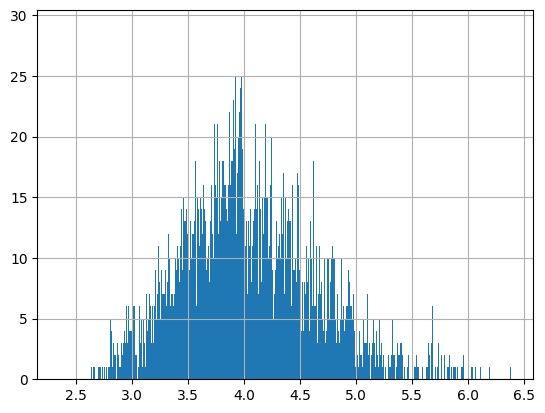

In [90]:
(df['netto'].dt.seconds/3600.0).hist(bins=1000)
plt.show() 

<Axes: xlabel='ak', ylabel='nettoSec'>

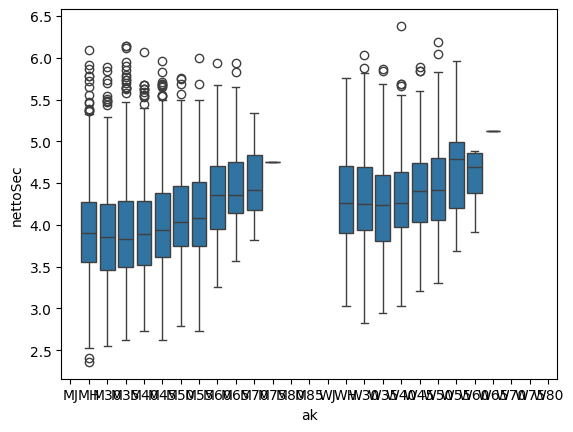

In [94]:
df['nettoSec'] = df['netto'].dt.seconds/3600.0

sns.boxplot(x='ak', y='nettoSec', data=df, 
            order=('MJ', 'MH', 'M30', 'M35', 'M40', 'M45', 'M50', 'M55', 'M60', 'M65', 'M70', 'M75', 'M80', 'M85', 
                   'WJ', 'WH', 'W30', 'W35', 'W40', 'W45', 'W50', 'W55', 'W60', 'W65', 'W70', 'W75', 'W80'))

In [49]:
df[['nation', 'netto']].groupby('nation').count().sort_values("netto", ascending=False).head(15)

,netto
nation,
GER,212935
GBR,34316
DNK,33319
USA,31345
FRA,23139
ITA,16648
ESP,11381
NLD,10918
SWE,10513


In [50]:
df[['year', 'netto']].groupby('year').count()

,netto
year,
2008,35732
2009,35015
2010,34001
2011,32914
2012,34269
2013,36472
2014,28945
2015,36758
2016,35991


In [57]:
df[['ak', 'netto']].groupby('ak').count().sort_values("ak").index

Index(['M30', 'M35', 'M40', 'M45', 'M50', 'M55', 'M60', 'M65', 'M70', 'M75',
       'M80', 'M85', 'MH', 'MJ', 'W30', 'W35', 'W40', 'W45', 'W50', 'W55',
       'W60', 'W65', 'W70', 'W75', 'W80', 'WH', 'WJ'],
      dtype='object', name='ak')

In [11]:
df.loc[df.ak.isin(['M', 'MJug', 'MU20', 'W', 'WJA', 'WJU20', 
                   'WJug', 'WU20']), ['ak', 'marathon', 'year']].groupby(['ak', 'year']).count()

,,marathon
ak,year,
